Inspiration:
- Forex exchange rate forecasting using deep recurrent neural networks [https://link.springer.com/article/10.1007/s42521-020-00019-x]
- Hybrid LSTM-GARCH [https://www.sciencedirect.com/science/article/abs/pii/S0957417418301416]

## Some data collection and cleaning

In [70]:
# a lot of importing
import yfinance as yf   
import pandas as pd
import numpy as np
from fredapi import Fred
import datetime as dt
from urllib.parse import urlparse
import os
import matplotlib.pyplot as plt
from data_processor import DataProcessor
from models import ArimaModel, CNNModel, LSTMModel
from helper import *
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend, optimizers
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from arch import arch_model
import time
import warnings
warnings.filterwarnings("ignore")

In [71]:
# Ticker symbols mapping
# key: Yahoo Finance ticker symbol
# value: data frame column name
# 'USDJPY=X': 'usdjpy', 'USDCNY=X': 'usdcny', 'BTC-USD': 'btc',

ticker_dict = {
        'AUDUSD=X': 'audusd',
        'TIO=F': 'iron_ore',
        'GC=F': 'gold',
        '^VIX': 'vix',
        'DX=F': 'dxy',
    }
rates_dict = {
    'FEDFUNDS': 'fed_rates',
    'FPCPITOTLZGAUS': 'cpi',
    'FPCPITOTLZGUSA': 'us_cpi',
    'RBA': 'rba_rates',
}

In [72]:
data_file = f"./data.parquet"


# Check if data file exists and is recent (e.g., less than 1 hour old)
if os.path.exists(data_file):
    file_age = dt.datetime.now() - dt.datetime.fromtimestamp(os.path.getmtime(data_file))
    
    if file_age < dt.timedelta(hours=1):  # Data is fresh
        print(f"Loading existing data from {data_file} (age: {file_age})")
        df = pd.read_parquet(data_file)
        df = df.ffill().bfill()  # Fill missing values
    else:
        print("Data file is outdated, downloading fresh data...")
        df = download_and_process(ticker_dict=ticker_dict, data_file=data_file)
else:
    print("No existing data file found, downloading...")
    df = download_and_process(ticker_dict=ticker_dict, data_file=data_file)

print(df.tail())

Data file is outdated, downloading fresh data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TIO=F']: YFPricesMissingError('possibly delisted; no price data found  (period=180d)')


✓ AUDUSD=X: 4267 records
✗ TIO=F: No data


[*********************100%***********************]  1 of 1 completed


✓ GC=F: 3394 records


[*********************100%***********************]  1 of 1 completed


✓ ^VIX: 2433 records


[*********************100%***********************]  1 of 1 completed


✓ DX=F: 3168 records
Merging all data...
Loading RBA interest rate data...
Loading Fed interest rate data...
Loading CPI data...
2011-01-01    3.303850
2012-01-01    1.762780
2013-01-01    2.449889
2014-01-01    2.487923
2015-01-01    1.508367
dtype: float64
Loading CPI data...
2011-01-01    3.156842
2012-01-01    2.069337
2013-01-01    1.464833
2014-01-01    1.622223
2015-01-01    0.118627
dtype: float64
Resetting index:
Data exported to data.parquet
                       audusd         gold   vix        dxy     sma_5  \
date                                                                    
2025-08-21 01:00:00  0.643376  3384.899902  15.7  98.175003  0.643443   
2025-08-21 02:00:00  0.642178  3384.899902  15.7  98.175003  0.643178   
2025-08-21 03:00:00  0.642385  3384.899902  15.7  98.175003  0.642930   
2025-08-21 04:00:00  0.642178  3380.800049  15.7  98.175003  0.642616   
2025-08-21 05:00:00  0.642591  3381.000000  15.7  98.184998  0.642542   

                       sma_10   

In [73]:
df['Log_Returns'] = np.log(df['audusd'] / df['audusd'].shift(1))
df.dropna(inplace=True)

In [74]:
X = df[df.first_valid_index():df.last_valid_index() - dt.timedelta(180)]

X

,audusd,gold,vix,dxy,sma_5,sma_10,ema_5,ema_10,momentum_5,momentum_10,std_5,std_10,rsi_14,rates,fed_rates,cpi,us_cpi,Log_Returns
date,,,,,,,,,,,,,,,,,,
2024-12-12 10:00:00,0.636858,2772.000000,13.760000,107.894997,0.636435,0.636567,0.636858,0.636858,-0.000422,0.000341,0.000400,0.000333,48.163304,4.35,4.48,3.161614,2.949525,0.000000
2024-12-12 11:00:00,0.636858,2772.000000,13.750000,107.894997,0.636435,0.636567,0.636858,0.636858,-0.000422,0.000341,0.000400,0.000333,48.163304,4.35,4.48,3.161614,2.949525,0.000000
2024-12-12 12:00:00,0.636858,2772.000000,13.710000,107.894997,0.636435,0.636567,0.636858,0.636858,-0.000422,0.000341,0.000400,0.000333,48.163304,4.35,4.48,3.161614,2.949525,0.000000
2024-12-12 13:00:00,0.636858,2772.000000,13.660000,107.894997,0.636435,0.636567,0.636858,0.636858,-0.000422,0.000341,0.000400,0.000333,48.163304,4.35,4.48,3.161614,2.949525,0.000000
2024-12-12 14:00:00,0.636858,2772.000000,13.790000,107.894997,0.636435,0.636567,0.636858,0.636858,-0.000422,0.000341,0.000400,0.000333,48.163304,4.35,4.48,3.161614,2.949525,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-21 18:00:00,0.636088,2958.500000,17.950001,106.529999,0.637417,0.638021,0.637200,0.637798,-0.002400,-0.002421,0.000941,0.000899,18.223517,4.10,4.33,3.161614,2.949525,-0.001725
2025-02-21 19:00:00,0.635457,2947.399902,18.600000,106.519997,0.636765,0.637698,0.636619,0.637373,-0.003259,-0.003231,0.000945,0.001172,18.686675,4.10,4.33,3.161614,2.949525,-0.000992
2025-02-21 20:00:00,0.635849,2948.399902,18.379999,106.535004,0.636427,0.637415,0.636363,0.637096,-0.001690,-0.002831,0.000900,0.001248,25.329269,4.10,4.33,3.161614,2.949525,0.000617


In [75]:
# Building a GARCH model using arch package
# Convert log returns to percentage returns for better numerical stability
returns = X['Log_Returns'].dropna() * 100

# Create GARCH(1,1) model
GARCH_model = arch_model(returns, vol='Garch', p=1, q=1)

# Fit the model
garch_fit = GARCH_model.fit(disp='off')

print(garch_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                819.975
Distribution:                  Normal   AIC:                          -1631.95
Method:            Maximum Likelihood   BIC:                          -1611.49
                                        No. Observations:                 1229
Date:                Thu, Aug 21 2025   Df Residuals:                     1228
Time:                        15:38:57   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.1732e-03  3.136e-03     -0.374      0.

- Parameters are significant 

In [76]:
# Making rolling predictions using the GARCH Model
# Get conditional volatility from the fitted model
conditional_volatility = garch_fit.conditional_volatility

# Create a DataFrame with the rolling predictions
GARCH_rolling_predictions = pd.DataFrame(
    conditional_volatility.values / 100,  # Convert back to decimal
    index=conditional_volatility.index,
    columns=['GARCH_rolling_predictions']
)

print(GARCH_rolling_predictions.head())

                     GARCH_rolling_predictions
date                                          
2024-12-12 10:00:00                   0.000604
2024-12-12 11:00:00                   0.000629
2024-12-12 12:00:00                   0.000649
2024-12-12 13:00:00                   0.000667
2024-12-12 14:00:00                   0.000683


In [77]:
# Making forward-looking predictions using the GARCH Model
# Forecast volatility for the next 1500 periods
forecast = garch_fit.forecast(horizon=30)

# Extract the variance forecast and convert to volatility
variance_forecast = forecast.variance.iloc[-1, :]
volatility_forecast = np.sqrt(variance_forecast) / 100  # Convert to decimal

# Create DataFrame for forward-looking predictions
future_dates = pd.date_range(start=X.index[-1] + pd.Timedelta(hours=1), periods=30, freq='H')
GARCH_forward_looking_predictions = pd.DataFrame(
    volatility_forecast.values,
    index=future_dates,
    columns=['GARCH_forward_looking_predictions']
)

print(GARCH_forward_looking_predictions.head())

                     GARCH_forward_looking_predictions
2025-02-21 23:00:00                           0.001070
2025-02-22 00:00:00                           0.001088
2025-02-22 01:00:00                           0.001105
2025-02-22 02:00:00                           0.001122
2025-02-22 03:00:00                           0.001138


In [78]:
# Column names are already correct from the arch implementation
# No renaming needed as we created the DataFrames with the correct column names
print("GARCH predictions ready for concatenation")
print("Rolling predictions shape:", GARCH_rolling_predictions.shape)
print("Forward predictions shape:", GARCH_forward_looking_predictions.shape)

GARCH predictions ready for concatenation
Rolling predictions shape: (1229, 1)
Forward predictions shape: (30, 1)


In [79]:
df = pd.concat([df, GARCH_rolling_predictions], axis=1)
df = pd.concat([df, GARCH_forward_looking_predictions], axis=1)

In [80]:
df['GARCH_forward_looking_predictions'] =  df['GARCH_forward_looking_predictions'].fillna(0)
df['GARCH_rolling_predictions'] =  df['GARCH_rolling_predictions'].fillna(0)

In [81]:
df

,audusd,gold,vix,dxy,sma_5,sma_10,ema_5,ema_10,momentum_5,momentum_10,std_5,std_10,rsi_14,rates,fed_rates,cpi,us_cpi,Log_Returns,GARCH_rolling_predictions,GARCH_forward_looking_predictions
2024-12-12 10:00:00,0.636858,2772.000000,13.76,107.894997,0.636435,0.636567,0.636858,0.636858,-0.000422,0.000341,0.000400,0.000333,48.163304,4.35,4.48,3.161614,2.949525,0.000000,0.000604,0.0
2024-12-12 11:00:00,0.636858,2772.000000,13.75,107.894997,0.636435,0.636567,0.636858,0.636858,-0.000422,0.000341,0.000400,0.000333,48.163304,4.35,4.48,3.161614,2.949525,0.000000,0.000629,0.0
2024-12-12 12:00:00,0.636858,2772.000000,13.71,107.894997,0.636435,0.636567,0.636858,0.636858,-0.000422,0.000341,0.000400,0.000333,48.163304,4.35,4.48,3.161614,2.949525,0.000000,0.000649,0.0
2024-12-12 13:00:00,0.636858,2772.000000,13.66,107.894997,0.636435,0.636567,0.636858,0.636858,-0.000422,0.000341,0.000400,0.000333,48.163304,4.35,4.48,3.161614,2.949525,0.000000,0.000667,0.0
2024-12-12 14:00:00,0.636858,2772.000000,13.79,107.894997,0.636435,0.636567,0.636858,0.636858,-0.000422,0.000341,0.000400,0.000333,48.163304,4.35,4.48,3.161614,2.949525,0.000000,0.000683,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-21 01:00:00,0.643376,3384.899902,15.70,98.175003,0.643443,0.643542,0.643395,0.643491,-0.000166,0.000455,0.000302,0.000288,50.000000,3.60,4.33,3.161614,2.949525,0.000643,0.000000,0.0
2025-08-21 02:00:00,0.642178,3384.899902,15.70,98.175003,0.643178,0.643393,0.642990,0.643252,-0.001322,-0.001488,0.000635,0.000513,32.335773,3.60,4.33,3.161614,2.949525,-0.001864,0.000000,0.0
2025-08-21 03:00:00,0.642385,3384.899902,15.70,98.175003,0.642930,0.643224,0.642788,0.643094,-0.001240,-0.001696,0.000658,0.000540,44.706370,3.60,4.33,3.161614,2.949525,0.000321,0.000000,0.0
2025-08-21 04:00:00,0.642178,3380.800049,15.70,98.175003,0.642616,0.643104,0.642585,0.642928,-0.001571,-0.001198,0.000533,0.000628,40.473572,3.60,4.33,3.161614,2.949525,-0.000321,0.000000,0.0


In [82]:
df.dropna(inplace=True)
df.drop(columns=['Log_Returns'], inplace=True)


In [83]:

df

,audusd,gold,vix,dxy,sma_5,sma_10,ema_5,ema_10,momentum_5,momentum_10,std_5,std_10,rsi_14,rates,fed_rates,cpi,us_cpi,GARCH_rolling_predictions,GARCH_forward_looking_predictions
2024-12-12 10:00:00,0.636858,2772.000000,13.76,107.894997,0.636435,0.636567,0.636858,0.636858,-0.000422,0.000341,0.000400,0.000333,48.163304,4.35,4.48,3.161614,2.949525,0.000604,0.0
2024-12-12 11:00:00,0.636858,2772.000000,13.75,107.894997,0.636435,0.636567,0.636858,0.636858,-0.000422,0.000341,0.000400,0.000333,48.163304,4.35,4.48,3.161614,2.949525,0.000629,0.0
2024-12-12 12:00:00,0.636858,2772.000000,13.71,107.894997,0.636435,0.636567,0.636858,0.636858,-0.000422,0.000341,0.000400,0.000333,48.163304,4.35,4.48,3.161614,2.949525,0.000649,0.0
2024-12-12 13:00:00,0.636858,2772.000000,13.66,107.894997,0.636435,0.636567,0.636858,0.636858,-0.000422,0.000341,0.000400,0.000333,48.163304,4.35,4.48,3.161614,2.949525,0.000667,0.0
2024-12-12 14:00:00,0.636858,2772.000000,13.79,107.894997,0.636435,0.636567,0.636858,0.636858,-0.000422,0.000341,0.000400,0.000333,48.163304,4.35,4.48,3.161614,2.949525,0.000683,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-21 01:00:00,0.643376,3384.899902,15.70,98.175003,0.643443,0.643542,0.643395,0.643491,-0.000166,0.000455,0.000302,0.000288,50.000000,3.60,4.33,3.161614,2.949525,0.000000,0.0
2025-08-21 02:00:00,0.642178,3384.899902,15.70,98.175003,0.643178,0.643393,0.642990,0.643252,-0.001322,-0.001488,0.000635,0.000513,32.335773,3.60,4.33,3.161614,2.949525,0.000000,0.0
2025-08-21 03:00:00,0.642385,3384.899902,15.70,98.175003,0.642930,0.643224,0.642788,0.643094,-0.001240,-0.001696,0.000658,0.000540,44.706370,3.60,4.33,3.161614,2.949525,0.000000,0.0
2025-08-21 04:00:00,0.642178,3380.800049,15.70,98.175003,0.642616,0.643104,0.642585,0.642928,-0.001571,-0.001198,0.000533,0.000628,40.473572,3.60,4.33,3.161614,2.949525,0.000000,0.0


In [84]:
# Dual-stream with custom lengths
model = LSTMModel(df, dual_stream=False, short_len=7, long_len=30)

TypeError: NeuralNetworkBaseModel.__init__() got an unexpected keyword argument 'dual_stream'

In [85]:
model = LSTMModel(data=df, target_col='audusd', train_ratio=0.80)

In [86]:
# Train the model with default parameters
model.fit(
    seq_len=20, 
    forecast_horizon=30, 
    epochs=100, 
    batch_size=256, 
    validation_split=0.2, 
    patience=20, 
    verbose=1
)

=== Starting LSTM Model Training Pipeline ===
1. Preparing data...
seq_len=20, forecast_horizon=30
Train size: 3452, Test size: 864
Shapes -> train_x: (3403, 20, 19) train_y: (3403, 30) y0_train: (3403, 30)
Shapes -> test_x: (815, 20, 19) test_y: (815, 30) y0_test: (815, 30)
2. Building model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 32)         │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,158 (109.99 KB)

 Trainable params: 28,158 (109.99 KB)

 Non-trainable params: 0 (0.00 B)

3. Training model...
Epoch 1/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6639 - mae: 0.6262  
Epoch 1: val_loss improved from None to 0.02782, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.6034 - mae: 0.5960 - val_loss: 0.0278 - val_mae: 0.1160 - learning_rate: 9.0000e-04
Epoch 2/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4350 - mae: 0.5021
Epoch 2: val_loss improved from 0.02782 to 0.01525, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4035 - mae: 0.4818 - val_loss: 0.0152 - val_mae: 0.0810 - learning_rate: 9.0000e-04
Epoch 3/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3050 - mae: 0.4169
Epoch 3: val_loss improved from 0.01525 to 0.00918, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2835 - mae: 0.4009 - val_loss: 0.0092 - val_mae: 0.0612 - learning_rate: 9.0000e-04
Epoch 4/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2177 - mae: 0.3472 
Epoch 4: val_loss improved from 0.00918 to 0.00628, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2042 - mae: 0.3349 - val_loss: 0.0063 - val_mae: 0.0489 - learning_rate: 9.0000e-04
Epoch 5/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1692 - mae: 0.3028 
Epoch 5: val_loss improved from 0.00628 to 0.00423, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1509 - mae: 0.2850 - val_loss: 0.0042 - val_mae: 0.0390 - learning_rate: 9.0000e-04
Epoch 6/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1244 - mae: 0.2555 
Epoch 6: val_loss improved from 0.00423 to 0.00303, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1163 - mae: 0.2471 - val_loss: 0.0030 - val_mae: 0.0325 - learning_rate: 9.0000e-04
Epoch 7/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0918 - mae: 0.2201 
Epoch 7: val_loss improved from 0.00303 to 0.00221, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0853 - mae: 0.2115 - val_loss: 0.0022 - val_mae: 0.0273 - learning_rate: 9.0000e-04
Epoch 8/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0707 - mae: 0.1897
Epoch 8: val_loss improved from 0.00221 to 0.00171, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0659 - mae: 0.1836 - val_loss: 0.0017 - val_mae: 0.0235 - learning_rate: 9.0000e-04
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0548 - mae: 0.1666
Epoch 9: val_loss improved from 0.00171 to 0.00134, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0535 - mae: 0.1641 - val_loss: 0.0013 - val_mae: 0.0202 - learning_rate: 9.0000e-04
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0421 - mae: 0.1461
Epoch 10: val_loss improved from 0.00134 to 0.00101, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0413 - mae: 0.1436 - val_loss: 0.0010 - val_mae: 0.0176 - learning_rate: 9.0000e-04
Epoch 11/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0367 - mae: 0.1351
Epoch 11: val_loss improved from 0.00101 to 0.00089, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0350 - mae: 0.1311 - val_loss: 8.8659e-04 - val_mae: 0.0161 - learning_rate: 9.0000e-04
Epoch 12/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0295 - mae: 0.1202
Epoch 12: val_loss improved from 0.00089 to 0.00071, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0285 - mae: 0.1178 - val_loss: 7.0731e-04 - val_mae: 0.0141 - learning_rate: 9.0000e-04
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0238 - mae: 0.1077
Epoch 13: val_loss improved from 0.00071 to 0.00054, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0233 - mae: 0.1058 - val_loss: 5.3575e-04 - val_mae: 0.0124 - learning_rate: 9.0000e-04
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0192 - mae: 0.0966
Epoch 14: val_loss improved from 0.00054 to 0.00047, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0191 - mae: 0.0958 - val_loss: 4.7151e-04 - val_mae: 0.0116 - learning_rate: 9.0000e-04
Epoch 15/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0172 - mae: 0.0907
Epoch 15: val_loss improved from 0.00047 to 0.00039, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0166 - mae: 0.0890 - val_loss: 3.9070e-04 - val_mae: 0.0104 - learning_rate: 9.0000e-04
Epoch 16/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0150 - mae: 0.0833
Epoch 16: val_loss improved from 0.00039 to 0.00035, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0142 - mae: 0.0813 - val_loss: 3.4878e-04 - val_mae: 0.0097 - learning_rate: 9.0000e-04
Epoch 17/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0127 - mae: 0.0772
Epoch 17: val_loss improved from 0.00035 to 0.00029, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0122 - mae: 0.0754 - val_loss: 2.9319e-04 - val_mae: 0.0089 - learning_rate: 9.0000e-04
Epoch 18/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0107 - mae: 0.0699
Epoch 18: val_loss improved from 0.00029 to 0.00025, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0107 - mae: 0.0693 - val_loss: 2.4587e-04 - val_mae: 0.0082 - learning_rate: 9.0000e-04
Epoch 19/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0097 - mae: 0.0658 
Epoch 19: val_loss improved from 0.00025 to 0.00022, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0090 - mae: 0.0642 - val_loss: 2.2011e-04 - val_mae: 0.0077 - learning_rate: 9.0000e-04
Epoch 20/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0602 
Epoch 20: val_loss did not improve from 0.00022
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0087 - mae: 0.0613 - val_loss: 2.2771e-04 - val_mae: 0.0075 - learning_rate: 9.0000e-04
Epoch 21/100
10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0082 - mae: 0.0591
Epoch 21: val_loss did not improve from 0.00022
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0078 - mae: 0.0577 - val_loss: 2.4444e-04 - val_mae: 0.0074 - learning_rate: 9.0000e-04
Epoch 22/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0549
Epoch 22: val_loss did not improve from 0.00022
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0068 - mae: 0.0536 - val_loss: 2.6282e-04 - val_mae: 0.0071 - learning_rate: 9.0000e-04
Epoch 23/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss:

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0066 - mae: 0.0517 - val_loss: 2.1674e-04 - val_mae: 0.0068 - learning_rate: 9.0000e-04
Epoch 24/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061 - mae: 0.0499 
Epoch 24: val_loss improved from 0.00022 to 0.00016, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0059 - mae: 0.0489 - val_loss: 1.6018e-04 - val_mae: 0.0063 - learning_rate: 9.0000e-04
Epoch 25/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0058 - mae: 0.0477 
Epoch 25: val_loss improved from 0.00016 to 0.00016, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0052 - mae: 0.0461 - val_loss: 1.5982e-04 - val_mae: 0.0061 - learning_rate: 9.0000e-04
Epoch 26/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056 - mae: 0.0455
Epoch 26: val_loss improved from 0.00016 to 0.00014, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0053 - mae: 0.0447 - val_loss: 1.3990e-04 - val_mae: 0.0059 - learning_rate: 9.0000e-04
Epoch 27/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054 - mae: 0.0439
Epoch 27: val_loss did not improve from 0.00014
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0052 - mae: 0.0434 - val_loss: 1.6480e-04 - val_mae: 0.0060 - learning_rate: 9.0000e-04
Epoch 28/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mae: 0.0415
Epoch 28: val_loss did not improve from 0.00014
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0047 - mae: 0.0411 - val_loss: 1.4481e-04 - val_mae: 0.0057 - learning_rate: 9.0000e-04
Epoch 29/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mae: 0.0386
Epoch 29: val_loss did not improve from 0.00014
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0042 - mae: 0.0384 - val_loss: 1.4280e-04 - val_mae: 0.0055 - learning_rate: 9.0000e-04
Epoch 30/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0037 - mae: 0.0363 - val_loss: 1.3488e-04 - val_mae: 0.0053 - learning_rate: 9.0000e-04
Epoch 31/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - mae: 0.0348 
Epoch 31: val_loss did not improve from 0.00013
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0038 - mae: 0.0352 - val_loss: 1.5100e-04 - val_mae: 0.0052 - learning_rate: 9.0000e-04
Epoch 32/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - mae: 0.0336
Epoch 32: val_loss did not improve from 0.00013
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036 - mae: 0.0341 - val_loss: 1.4104e-04 - val_mae: 0.0054 - learning_rate: 9.0000e-04
Epoch 33/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - mae: 0.0331 
Epoch 33: val_loss improved from 0.00013 to 0.00013, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - mae: 0.0326 - val_loss: 1.2570e-04 - val_mae: 0.0052 - learning_rate: 9.0000e-04
Epoch 34/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mae: 0.0323
Epoch 34: val_loss did not improve from 0.00013
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0316 - val_loss: 1.2809e-04 - val_mae: 0.0051 - learning_rate: 9.0000e-04
Epoch 35/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mae: 0.0309
Epoch 35: val_loss improved from 0.00013 to 0.00012, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - mae: 0.0307 - val_loss: 1.1916e-04 - val_mae: 0.0050 - learning_rate: 9.0000e-04
Epoch 36/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0307
Epoch 36: val_loss did not improve from 0.00012

Epoch 36: ReduceLROnPlateau reducing learning rate to 8.999999845400454e-05.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0306 - val_loss: 1.3743e-04 - val_mae: 0.0053 - learning_rate: 9.0000e-04
Epoch 37/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mae: 0.0297
Epoch 37: val_loss did not improve from 0.00012
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - mae: 0.0301 - val_loss: 1.3739e-04 - val_mae: 0.0053 - learning_rate: 9.0000e-05
Epoch 38/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - mae: 0.0301
Epoch 38: val_loss did not improve from 0.00012
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - mae: 0.0301 - val_loss: 1.2536e-04 - val_mae: 0.0052 - learning_

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - mae: 0.0302 - val_loss: 1.1879e-04 - val_mae: 0.0050 - learning_rate: 9.0000e-05
Epoch 43/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mae: 0.0292 
Epoch 43: val_loss improved from 0.00012 to 0.00012, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025 - mae: 0.0289 - val_loss: 1.1622e-04 - val_mae: 0.0050 - learning_rate: 9.0000e-05
Epoch 44/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mae: 0.0278 
Epoch 44: val_loss improved from 0.00012 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0024 - mae: 0.0281 - val_loss: 1.1478e-04 - val_mae: 0.0049 - learning_rate: 9.0000e-05
Epoch 45/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mae: 0.0287
Epoch 45: val_loss did not improve from 0.00011
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - mae: 0.0288 - val_loss: 1.1724e-04 - val_mae: 0.0049 - learning_rate: 9.0000e-05
Epoch 46/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mae: 0.0283
Epoch 46: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5



Epoch 46: ReduceLROnPlateau reducing learning rate to 9.000000136438758e-06.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025 - mae: 0.0286 - val_loss: 1.1063e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-05
Epoch 47/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mae: 0.0285
Epoch 47: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - mae: 0.0288 - val_loss: 1.1030e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-06
Epoch 48/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - mae: 0.0293
Epoch 48: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - mae: 0.0288 - val_loss: 1.0995e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-06
Epoch 49/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - mae: 0.0293 
Epoch 49: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028 - mae: 0.0287 - val_loss: 1.0962e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-06
Epoch 50/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mae: 0.0288 
Epoch 50: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028 - mae: 0.0289 - val_loss: 1.0933e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-06
Epoch 51/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mae: 0.0290
Epoch 51: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - mae: 0.0284 - val_loss: 1.0889e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-06
Epoch 52/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mae: 0.0283
Epoch 52: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - mae: 0.0287 - val_loss: 1.0859e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-06
Epoch 53/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mae: 0.0285
Epoch 53: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - mae: 0.0285 - val_loss: 1.0832e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-06
Epoch 54/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mae: 0.0286 
Epoch 54: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - mae: 0.0285 - val_loss: 1.0807e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-06
Epoch 55/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mae: 0.0284
Epoch 55: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - mae: 0.0286 - val_loss: 1.0788e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-06
Epoch 56/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mae: 0.0281 
Epoch 56: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5



Epoch 56: ReduceLROnPlateau reducing learning rate to 9.000000318337698e-07.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - mae: 0.0284 - val_loss: 1.0756e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-06
Epoch 57/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mae: 0.0289 
Epoch 57: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - mae: 0.0285 - val_loss: 1.0753e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-07
Epoch 58/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mae: 0.0289 
Epoch 58: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - mae: 0.0288 - val_loss: 1.0749e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-07
Epoch 59/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mae: 0.0282
Epoch 59: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - mae: 0.0283 - val_loss: 1.0746e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-07
Epoch 60/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - mae: 0.0288
Epoch 60: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025 - mae: 0.0281 - val_loss: 1.0742e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-07
Epoch 61/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - mae: 0.0302 
Epoch 61: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028 - mae: 0.0285 - val_loss: 1.0740e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-07
Epoch 62/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mae: 0.0283 
Epoch 62: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - mae: 0.0285 - val_loss: 1.0737e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-07
Epoch 63/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mae: 0.0285
Epoch 63: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025 - mae: 0.0280 - val_loss: 1.0734e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-07
Epoch 64/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mae: 0.0286 
Epoch 64: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - mae: 0.0280 - val_loss: 1.0732e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-07
Epoch 65/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - mae: 0.0293 
Epoch 65: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - mae: 0.0283 - val_loss: 1.0730e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-07
Epoch 66/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - mae: 0.0280 
Epoch 66: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5



Epoch 66: ReduceLROnPlateau reducing learning rate to 9.000000318337698e-08.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - mae: 0.0281 - val_loss: 1.0726e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-07
Epoch 67/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mae: 0.0281 
Epoch 67: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - mae: 0.0286 - val_loss: 1.0726e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-08
Epoch 68/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mae: 0.0279 
Epoch 68: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - mae: 0.0284 - val_loss: 1.0725e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-08
Epoch 69/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mae: 0.0283 
Epoch 69: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - mae: 0.0284 - val_loss: 1.0725e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-08
Epoch 70/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - mae: 0.0276 
Epoch 70: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - mae: 0.0283 - val_loss: 1.0725e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-08
Epoch 71/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mae: 0.0284
Epoch 71: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - mae: 0.0288 - val_loss: 1.0725e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-08
Epoch 72/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mae: 0.0290
Epoch 72: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - mae: 0.0284 - val_loss: 1.0724e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-08
Epoch 73/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mae: 0.0277 
Epoch 73: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - mae: 0.0282 - val_loss: 1.0724e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-08
Epoch 74/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - mae: 0.0291 
Epoch 74: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028 - mae: 0.0288 - val_loss: 1.0724e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-08
Epoch 75/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mae: 0.0293 
Epoch 75: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - mae: 0.0286 - val_loss: 1.0723e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-08
Epoch 76/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - mae: 0.0290 
Epoch 76: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5



Epoch 76: ReduceLROnPlateau reducing learning rate to 9.000000034120604e-09.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - mae: 0.0287 - val_loss: 1.0723e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-08
Epoch 77/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mae: 0.0275
Epoch 77: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - mae: 0.0282 - val_loss: 1.0723e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-09
Epoch 78/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mae: 0.0277
Epoch 78: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - mae: 0.0282 - val_loss: 1.0723e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-09
Epoch 79/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mae: 0.0289
Epoch 79: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - mae: 0.0285 - val_loss: 1.0723e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-09
Epoch 80/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mae: 0.0278
Epoch 80: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - mae: 0.0279 - val_loss: 1.0723e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-09
Epoch 81/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0024 - mae: 0.0282
Epoch 81: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0026 - mae: 0.0283 - val_loss: 1.0723e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-09
Epoch 82/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mae: 0.0282 
Epoch 82: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - mae: 0.0285 - val_loss: 1.0723e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-09
Epoch 83/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mae: 0.0281 
Epoch 83: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - mae: 0.0278 - val_loss: 1.0723e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-09
Epoch 84/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mae: 0.0275 
Epoch 84: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0023 - mae: 0.0276 - val_loss: 1.0723e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-09
Epoch 85/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mae: 0.0288 
Epoch 85: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - mae: 0.0287 - val_loss: 1.0722e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-09
Epoch 86/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mae: 0.0283 
Epoch 86: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5



Epoch 86: ReduceLROnPlateau reducing learning rate to 8.99999985648492e-10.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - mae: 0.0284 - val_loss: 1.0722e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-09
Epoch 87/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - mae: 0.0279
Epoch 87: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028 - mae: 0.0282 - val_loss: 1.0722e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-10
Epoch 88/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mae: 0.0283
Epoch 88: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - mae: 0.0286 - val_loss: 1.0722e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-10
Epoch 89/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mae: 0.0275
Epoch 89: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024 - mae: 0.0279 - val_loss: 1.0722e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-10
Epoch 90/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mae: 0.0289
Epoch 90: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025 - mae: 0.0284 - val_loss: 1.0722e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-10
Epoch 91/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mae: 0.0288
Epoch 91: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - mae: 0.0287 - val_loss: 1.0722e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-10
Epoch 92/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mae: 0.0292 
Epoch 92: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - mae: 0.0282 - val_loss: 1.0722e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-10
Epoch 93/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mae: 0.0285
Epoch 93: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - mae: 0.0284 - val_loss: 1.0722e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-10
Epoch 94/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mae: 0.0265 
Epoch 94: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0023 - mae: 0.0277 - val_loss: 1.0722e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-10
Epoch 95/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - mae: 0.0295 
Epoch 95: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0287 - val_loss: 1.0722e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-10
Epoch 96/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - mae: 0.0291
Epoch 96: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5



Epoch 96: ReduceLROnPlateau reducing learning rate to 8.999999634440315e-11.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - mae: 0.0288 - val_loss: 1.0722e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-10
Epoch 97/100
 8/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mae: 0.0275 
Epoch 97: val_loss improved from 0.00011 to 0.00011, saving model to LSTM-weights-best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025 - mae: 0.0280 - val_loss: 1.0722e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-11
Epoch 98/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mae: 0.0284
Epoch 98: val_loss did not improve from 0.00011
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025 - mae: 0.0284 - val_loss: 1.0722e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-11
Epoch 99/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0023 - mae: 0.0275
Epoch 99: val_loss did not improve from 0.00011
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0026 - mae: 0.0281 - val_loss: 1.0722e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-11
Epoch 100/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mae: 0.0284
Epoch 100: val_loss did not improve from 0.00011
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - mae: 0.0281 - val_loss: 1.0722e-04 - val_mae: 0.0048 - learning_rate: 9.0000e-11
{'test_loss': 0.00010722415754571557, 'test_mae': 0.004779

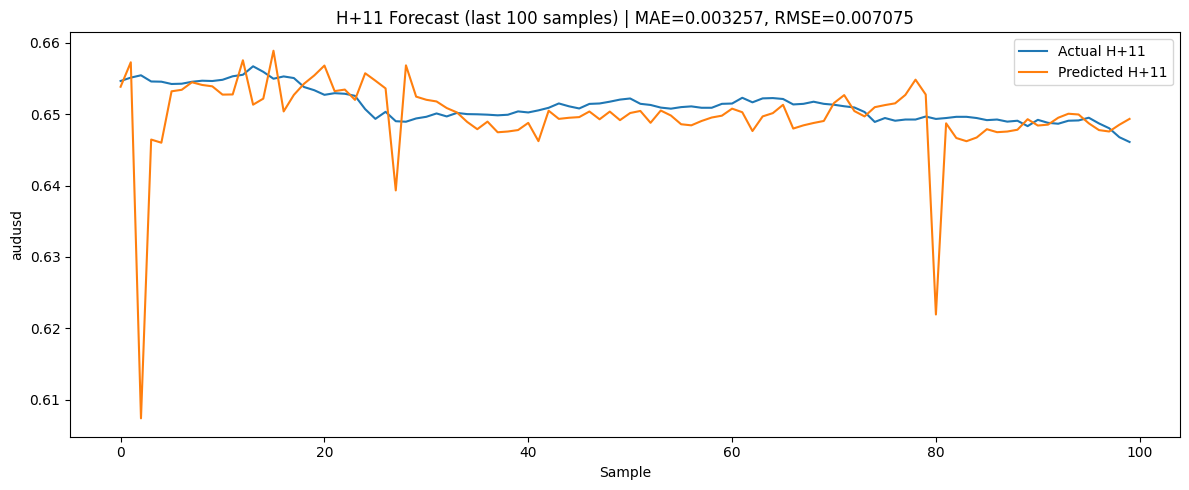

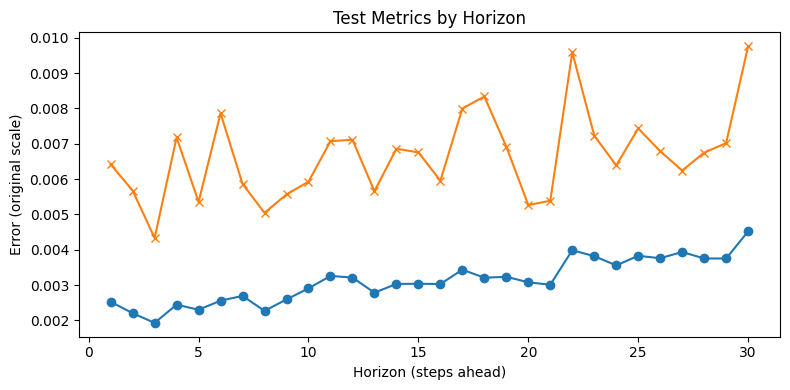

In [ ]:
# Plot predictions for horizon H+11 (index 10)
model.plot_results(N=100, horizon=10)

# Plot MAE by horizon
model.plot_metrics_by_horizon()